## Importing Necessary Libraries

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

We will load the train dataset - and divide this into train + validation. We will tune the hyperparameters of our strategy on the train set, and check the performance on the validation dataset. This will ensure we develop a robust model, and avoid overfiitng

This strategy includes using the MACD indi

In [165]:
#Load the dataset
df_fine = pd.read_csv("data/btcusdt_1h_train.csv")
#Convert the datetime into pandas datetime format
df_fine["datetime"] = pd.to_datetime(df_fine["datetime"])
#Drop unnecessary colummns
df_fine = df_fine.drop(columns = ["Unnamed: 0"])


#Select a particular timestamp, and filter the original dataframe to obtain daily data
time_stamp = "21:30:00"
df = df_fine[df_fine['datetime'].dt.time == pd.to_datetime(time_stamp).time()]

#Display a few rows of the dataframe
display(df.head())



,datetime,open,high,low,close,volume
16,2018-01-01 21:30:00,13247.00,13247.08,12966.42,13018.00,367.393566
40,2018-01-02 21:30:00,13690.02,13842.88,13584.99,13590.02,1020.856756
64,2018-01-03 21:30:00,15045.00,15130.00,14901.93,15010.06,477.866959
87,2018-01-04 21:30:00,14367.99,14494.99,14238.01,14469.97,1129.730622
111,2018-01-05 21:30:00,16094.99,16500.00,16087.73,16449.00,1007.615517


## Generating the MACD signal

We will now generate the MACD signal, using the TALIB library. This takes in 3 parameters - fast, slow, signal, and outputs macd, signal, and the histogram line. We will just focus on the signal parameter for our analysis.

In [166]:

#Generate the MACD signal calculated on the open prices
fast = 12
slow = 26
signal = 9
_, signal, _ = talib.MACD(df["open"], fastperiod=fast, slowperiod=slow, signalperiod=signal)

df['signal'] = signal

#Calculate the signal of the previous day
shifted_signal = df['signal'].shift(1)



## Visualising the MACD signal

We will now visualaise the MACD signal, and check its relation to the open price, and come up with a basic strategy

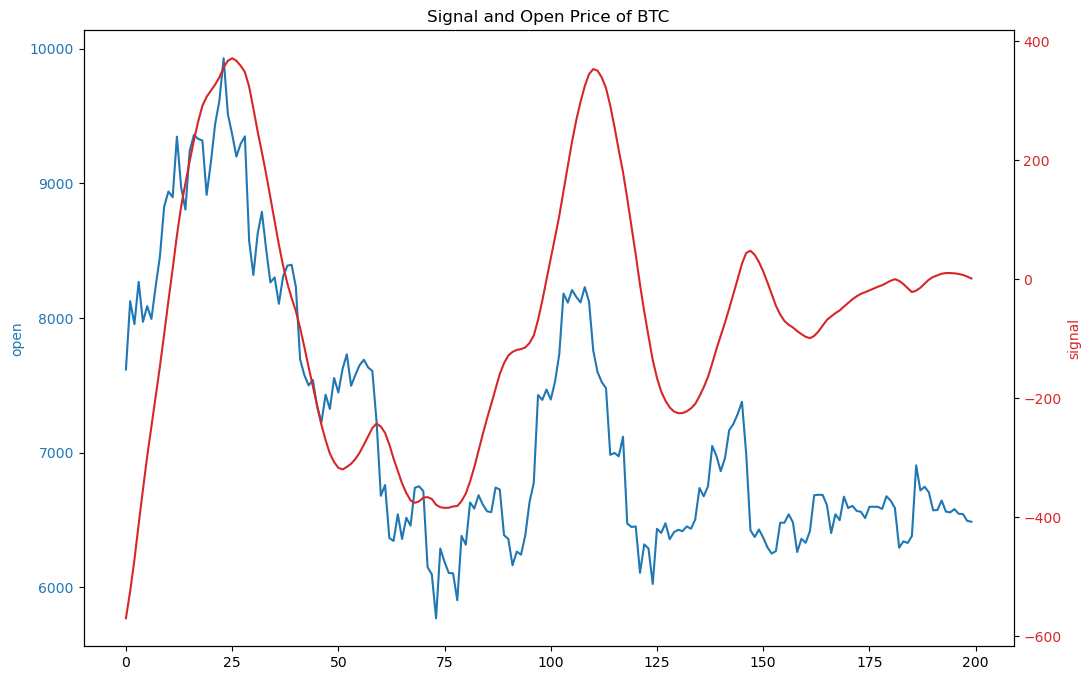

In [167]:
#Look at a few entries of the dataframe
df_slice = df[100:300].reset_index()
# print(len(df_slice))

# Create a Matplotlib figure and axis
fig, ax1 = plt.subplots(figsize = (12,8))

# Plot the first column on the primary y-axis
# ax1.set_xlabel('Date')
ax1.set_ylabel('open', color='tab:blue')
ax1.plot(df_slice['open'], color='tab:blue')
# ax1.scatter(df_slice.index,df_slice['open'],
#  color='tab:blue')

ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second column on the secondary y-axis
ax2.set_ylabel('signal', color='tab:red')
ax2.plot( df_slice['signal'], color='tab:red')


ax2.tick_params(axis='y', labelcolor='tab:red')
plt.title('Signal and Open Price of BTC')
plt.xticks(rotation=45)
plt.show()

## Coming up with a basic strategy

As seen from the graph, we will come up with a basic stategy: we will generate a buy signal if signal(t) > signal (t-1), otherwise we will generate a sell signal. This will be stored in the flag column

We will also start testing our strategy on the train set - where we will use a 75%-25% train test split


In [168]:
#Generate buy/sell signals
df['flag'] = np.where(df['signal'] > shifted_signal, 1, 0)
df['flag'] = np.where(df['signal'] < shifted_signal, -1, df['flag'])


#Train test split
train_test_split = 0.75
df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]

## Helper Functions

We will use 2 main functions throughout the analysis - one is for generating the log file, one is for analysing the trades and calculating PNL (this is similar to the backtesting engine sans a few features not required now)

The first one, to generate the log file, also includes a simple stoploss as an input

In [169]:
def gen_logs(df, thresh = -0.03):

    """
    Takes in input as dataframe (with the flag column), and the stoploss threshold
    Output is a log file which contains +1 that indicates buy, -1 that indicates sell, and 0 to do nothing
    """
    
    #stoploss
    exit_loss = 0
    #disable trading to flag to be enabled, once we hit stoploss to stop trading
    disable_trading = 0
    compare = 0
     
    logs = []

    for i in range(len(df)):
        if df["flag"].iloc[i] == 1 and compare == 0:
            # No open trade, encouter buy singal
            exit_loss = 0
            buy_price = df["open"].iloc[i]
            
            compare = 1
            logs.append(1)

        #Once we open a trade, we have to check in df_fine whether to exit or not

        elif (df["flag"].iloc[i] != -1 and compare == 1):
            # Current buy trade, encounter buy signal or no signal - do nothing, update stop loss
            logs.append(0)

            #calculate pnl, if we exit now
            sell_price = df["open"].iloc[i]
            exit_loss = (sell_price - buy_price)/buy_price 
            

            #exit trade, if the loss is higher than stop loss
            if exit_loss < thresh and disable_trading == 0:
                logs[-1] = -1

                disable_trading = 1


        elif df["flag"].iloc[i] == -1 and compare == 1:
            # Current buy trade, encounter sell signal

            #exit trade
            logs.append(-1)
            compare = 0
            exit_loss = 0

            #if trade was already exited before, check for disable trading flag here, do nothing here
            if disable_trading == 1:
                disable_trading = 0
                compare = -1 #the trade that we opened above is a sell trade


        #SHORT TRADES
        elif df["flag"].iloc[i] == -1 and compare == 0:
            # No open trade, enounter sell siganl 
            exit_loss = 0
            sell_price = df["open"].iloc[i]
            
            compare = -1
            logs.append(-1)


        elif (df["flag"].iloc[i] != 1 and compare == -1):
            # Current sell trade, encounter sell signal or no signal - do nothing, update stop loss
            logs.append(0)

            #calculate pnl, if we exit now
            buy_price = df["open"].iloc[i]
            exit_loss = (sell_price - buy_price)/sell_price 
        

            #exit trade, if the loss is higher than stop loss
            if exit_loss < thresh and disable_trading == 0:
                logs[-1] = 1
                disable_trading = 1

        elif df["flag"].iloc[i] == 1 and compare == -1:

            #exit trade
            logs.append(1)
            compare = 0
            exit_loss = 0

            #if trade was already exited before, check for disable trading flag here, do nothing here
            if disable_trading == 1:
                disable_trading = 0
                compare = 1

        elif df["flag"].iloc[i] == 0 and compare == 0:
            logs.append(0)

    #close out positions (if needed)
    
    logs = np.array(logs)

    if logs[-1] != 0 and np.sum(logs) != 0:
        logs[-1] = 0
    elif logs[-1] != 0 and np.sum(logs) == 0:
        pass
    else:
        logs[-1] = -np.sum(logs)

    df["logs"] = logs

    return df


In [170]:
def trade_analysis(df):
    """
    Generates static PNL (including transaction cost) of a given set of trades
    """

    df_trades= df[df["logs"] != 0].reset_index(drop = True)
 
    returns = []
    signals = []

    signs = []

    for i in range(0, len(df_trades), 2):

        entry_price = df_trades["open"].iloc[i]
        exit_price = df_trades["open"].iloc[i+1]

        sign = df_trades["logs"].iloc[i]

        returns.append((exit_price-entry_price)/entry_price*sign)


    return sum(returns) - 0.15/100*len(returns)

## Hyperparameter Tuning

Our goal is now to obtain a set of optimal hyperparameters, that will generate the maximum PNL on the train set. For this we will perform a grid search on a possible range of parameters and find the best ones

In [97]:
pnls = []
params = []
max_pnl = 0
time_vals = np.array(['05:30:00', '06:30:00', '07:30:00', '08:30:00', '09:30:00',
       '10:30:00', '11:30:00', '12:30:00', '13:30:00', '14:30:00',
       '15:30:00', '16:30:00', '17:30:00', '18:30:00', '19:30:00',
       '20:30:00', '21:30:00', '22:30:00', '23:30:00', '00:30:00',
       '01:30:00', '02:30:00', '03:30:00', '04:30:00'], dtype=object)


for f in [10 + 4*i for i in range(5)]:
    for s in [f+2 + 2*j for j in range(5)]:
        for sig in range(6,s+1,4):
            for thresh in [-0.1 + 0.02*k for k in range(5)]:
                for val in time_vals:
                    
                    df = df_fine[df_fine['datetime'].dt.time == pd.to_datetime(val).time()]

                    
                    _, signal, _ = talib.MACD(df["open"], fastperiod=f, slowperiod=s, signalperiod=sig)

                    df['signal'] = signal

                    #Calculate the signal of the previous day
                    shifted_signal = df['signal'].shift(1)

                    #Generate buy/sell signals
                    df['flag'] = np.where(df['signal'] > shifted_signal, 1, 0)
                    df['flag'] = np.where(df['signal'] < shifted_signal, -1, df['flag'])


                    #Train test split
                    train_test_split = 0.75
                    df_train = df[0: int(train_test_split*len(df))]
                    df_val = df[int(train_test_split*len(df)):]

                    pnl = trade_analysis(gen_logs(df_train, thresh))
                    pnls.append(pnl)

                    if pnl > max_pnl:
                        print(f"New high PNL = {pnl}, params: {f, s, sig, thresh, val} ")
                        max_pnl = pnl
    

                    pnls.append(pnl)
                    params.append((f, s, sig, thresh, val))

New high PNL = 0.07447262911691893, params: (10, 12, 6, -0.1, '05:30:00') 
New high PNL = 0.45003387576313647, params: (10, 12, 6, -0.1, '06:30:00') 
New high PNL = 0.5303571181621166, params: (10, 12, 6, -0.1, '07:30:00') 
New high PNL = 0.6851404209562537, params: (10, 12, 6, -0.1, '17:30:00') 
New high PNL = 0.7287041203525852, params: (10, 12, 6, -0.1, '19:30:00') 
New high PNL = 0.9453785223923663, params: (10, 12, 6, -0.1, '20:30:00') 
New high PNL = 1.0788493181567533, params: (10, 12, 6, -0.1, '21:30:00') 
New high PNL = 1.2447913508500323, params: (10, 12, 6, -0.08, '21:30:00') 
New high PNL = 1.355613664333779, params: (10, 12, 6, -0.020000000000000004, '17:30:00') 
New high PNL = 1.5487713777126835, params: (10, 12, 6, -0.020000000000000004, '21:30:00') 
New high PNL = 1.6395848422666643, params: (10, 16, 14, -0.1, '21:30:00') 
New high PNL = 1.7218591550764868, params: (10, 16, 14, -0.060000000000000005, '21:30:00') 
New high PNL = 1.7805495451589903, params: (10, 16, 14, -

## Calculating PNL on validation dataset

To avoid overfitting we will check the performance of our optimal hyperparameters on the validation set

In [171]:
f = 14
s = 20
sig = 14
val = '21:30:00'
thresh = -0.1

df = df_fine[df_fine['datetime'].dt.time == pd.to_datetime(val).time()]


_, signal, _ = talib.MACD(df["open"], fastperiod=f, slowperiod=s, signalperiod=sig)

df['signal'] = signal

#Calculate the signal of the previous day
shifted_signal = df['signal'].shift(1)

#Generate buy/sell signals
df['flag'] = np.where(df['signal'] > shifted_signal, 1, 0)
df['flag'] = np.where(df['signal'] < shifted_signal, -1, df['flag'])


#Train test split
train_test_split = 0.75
df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]

df_train = gen_logs(df_train, thresh)
df_val = gen_logs(df_val, thresh)
df = gen_logs(df, thresh)

print(trade_analysis(gen_logs(df_train, thresh)), trade_analysis(gen_logs(df_val, thresh)))


2.8193534133578875 0.9973462968464395


## Analysing the trades, and trying to improve our strategy
We will now proceed with the best parameters obtained until now, and analyse the trades on the train dataset
We will now look at the trades that we have done, and try to remove some of the bad trades

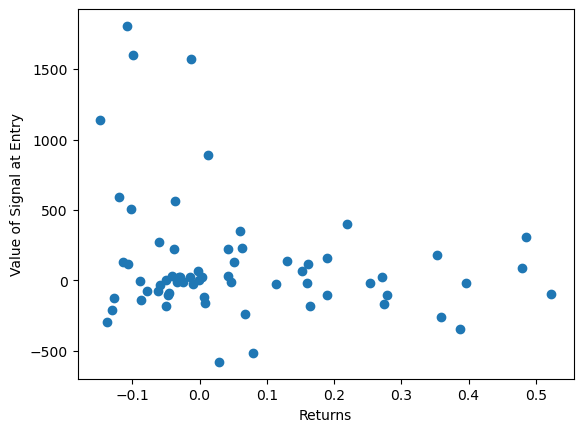

In [172]:
df_trades= df[df["logs"] != 0].reset_index(drop = True)

returns = []
signals = []

signs = []

for i in range(0, len(df_trades), 2):

    entry_price = df_trades["open"].iloc[i]
    exit_price = df_trades["open"].iloc[i+1]

    #Value of the signal parameter at the entry
    signals.append(df_trades["signal"].iloc[i])

    sign = df_trades["logs"].iloc[i]

    returns.append((exit_price-entry_price)/entry_price*sign)

# plt.figure(figsize = (10, 12))
plt.scatter(returns, signals)
plt.xlabel("Returns")
plt.ylabel("Value of Signal at Entry")
plt.show()


## Observations

We can clearly see that if the absolute value of the signal at entry is very high, this leads to mostly negative returns, hence we will set a threshold of generating flags while entering. Now, we will find an optimal hyperparameter for the signal threshold

In [173]:
    
for signal_thresh in [300 + 100*i for i in range(10)]:

    #specify optimal parameters calculated previously
    f = 14
    s = 20
    sig = 14
    val = '21:30:00'
    thresh = -0.1

    df = df_fine[df_fine['datetime'].dt.time == pd.to_datetime(val).time()]


    _, signal, _ = talib.MACD(df["open"], fastperiod=f, slowperiod=s, signalperiod=sig)

    df['signal'] = signal

    #Calculate the signal of the previous day
    shifted_signal = df['signal'].shift(1)
    
    df['flag'] = np.where(np.logical_and(df['signal'] > shifted_signal, abs(df["signal"]) < signal_thresh), 1, 0)
    df['flag'] = np.where(np.logical_and(df['signal'] < shifted_signal, abs(df["signal"]) < signal_thresh), -1, df['flag'])

    train_test_split = 0.75
    df_train = df[0: int(train_test_split*len(df))]
    df_val = df[int(train_test_split*len(df)):]

    df_train = gen_logs(df_train, thresh)
    df_val = gen_logs(df_val, thresh)


    print(trade_analysis(gen_logs(df_train, thresh)), trade_analysis(gen_logs(df_val, thresh)), signal_thresh)

2.657769409593789 1.0583101588726442 300
2.5601453826788694 1.629957475238713 400
2.6014507718601205 1.6492902592444558 500
2.8193534133578875 1.5078137463221353 600
2.8193534133578875 1.3771000852494 700
2.8193534133578875 1.22719405356849 800
2.8193534133578875 1.0594233568387763 900
2.8193534133578875 0.9797551822740161 1000
2.8193534133578875 0.7490061708113573 1100
2.8193534133578875 0.8350301163086696 1200


## Observations 

Note that, the train result is mostly unaffected by our choice of parameter, this is because most of the "bad points" are in the validation dataset, thus we look at both train and validation (since our train data is biased), to get a more general idea.

## Towards a better risk management system

We now want to improve our stoploss architecture. Currently, we are employing a very crude form of stoploss which checks the stoploss once a day. To improve upon this, the first idea is to use a finer stoploss - such as on the 1 hour dataset
This means that while we will only enter on the daily sampled timeframe, to check for stoploss we will use the 1hour data. This will help us improve our execution

In [174]:
df_fine = pd.read_csv("data/btcusdt_1h_train.csv")
df_fine["datetime"] = pd.to_datetime(df_fine["datetime"])
df_fine = df_fine.drop(columns = ["Unnamed: 0"])

time_vals = np.array(['21:30:00'], dtype=object)
# time_vals = np.array(['09:30:00'], dtype=object)

#Select a particular timestamp, and filter the original dataframe to obtain daily data
time_stamp = "21:30:00"
df = df_fine[df_fine['datetime'].dt.time == pd.to_datetime(time_stamp).time()]

fast = 14
slow = 20
signal = 14
macd, signal, _ = talib.MACD(df["open"], fastperiod=fast, slowperiod=slow, signalperiod=signal)
df['macd'] = macd
df['signal'] = signal

shifted_signal = df['signal'].shift(1)

signal_thresh = 500
df['flag'] = np.where(np.logical_and(df['signal'] > shifted_signal, abs(df["signal"]) < signal_thresh), 1, 0)
df['flag'] = np.where(np.logical_and(df['signal'] < shifted_signal, abs(df["signal"]) < signal_thresh), -1, df['flag'])

train_test_split = 0.75

df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]

thresh = -0.1

## Calculate the original Train PNL (includes the crude form of stoploss)
pnl_train = trade_analysis(gen_logs(df_train, thresh))

print(pnl_train.round(4))



2.6015


In [175]:
## Merge our dataframe, with the finer dataframe (1hr ticksize)
df = df.drop(columns= ["open", "high", "low", "close", "volume"])
df = df_fine.merge(df, on='datetime', how='left')
df = df.fillna(0)
display(df)

,datetime,open,high,low,close,volume,macd,signal,flag
0,2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199,0.000000,0.000000,0.0
1,2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006,0.000000,0.000000,0.0
2,2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572,0.000000,0.000000,0.0
3,2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030,0.000000,0.000000,0.0
4,2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
29803,2021-05-31 19:30:00,36721.29,36853.94,36333.44,36620.39,4333.305783,0.000000,0.000000,0.0
29804,2021-05-31 20:30:00,36620.39,37149.99,36580.01,36961.16,4167.824255,0.000000,0.000000,0.0
29805,2021-05-31 21:30:00,36961.16,37457.07,36843.24,37117.24,6313.228329,-2038.609648,-1905.427895,0.0
29806,2021-05-31 22:30:00,37117.21,37178.16,36673.41,36934.73,4003.907256,0.000000,0.000000,0.0


In [176]:

## Divide the data into train and val
train_test_split = 0.75

df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]

## Find the optimal threshold value
for thresh in [-0.24 + 0.02*i for i in range(12)]:
    pnl_train = trade_analysis(gen_logs(df_train, thresh))

    print(pnl_train.round(4), thresh)

2.7735 -0.24
2.7735 -0.22
2.7735 -0.19999999999999998
2.7735 -0.18
2.6678 -0.15999999999999998
2.4095 -0.13999999999999999
2.235 -0.12
1.7998 -0.09999999999999998
1.8483 -0.07999999999999999
1.986 -0.06
1.6776 -0.03999999999999998
0.4419 -0.01999999999999999


## Observations

We see that the highest PNL is when there is 18-24% stoploss. This effectively means, there is no stoploss at this range, and all trades are exited based on the true signal. Even though this gives a better PNL, this is clearly not the right value to be chosen, since we can get worse points in the validation and test dataset

We can analyse why this is the case


In [181]:
## Checking is stoploss matters?



def stoploss_plot(df):
    df_trades = df[df["logs"] != 0]
    index = df_trades.index.to_list()

    #returns all stores the final returns of each trade
    returns_all = []

    #returns_low_all stores the lowest dip of each return
    returns_low_all = []
    trades = []

    #loop of over all trades in increments of 2
    for i in range(0, len(df_trades), 2):
        #obtain the prices achieved by btc when the trade was open
        prices = df["open"][index[i]: index[i+1]]

        if df["logs"].iloc[index[i]] == 1:

            buy_price = df["open"].iloc[index[i]]
            sell_price = df["open"].iloc[index[i+1]]
            
            if len(prices) > 2:
                #caclulate returns
                returns = (sell_price - buy_price)/buy_price
                returns_all.append(returns)

                #calculate lowest dip
                low = min(prices[:-1])
                returns_low = (low - buy_price)/buy_price
                returns_low_all.append(returns_low)
                trades.append("long")

        elif df["logs"].iloc[index[i]] == -1:
            sell_price = df["open"].iloc[index[i]]
            buy_price = df["open"].iloc[index[i+1]]

            if len(prices) > 2:
                #caclulate returns
                returns = (sell_price - buy_price)/sell_price
                returns_all.append(returns)

                #caclulate lowest dip
                high = max(prices[:-1])
                returns_low = (sell_price - high)/sell_price
                returns_low_all.append(returns_low)
                trades.append("short")


    colors = ['red', 'blue']

    plt.figure(figsize=(12,8))
    # Create a scatter plot and color code the points based on the labels
    for j,trade in enumerate(set(trades)):
        print(trade)
        x_group = [returns_all[i] for i in range(len(returns_all)) if trades[i] == trade]
        y_group = [returns_low_all[i] for i in range(len(returns_all)) if trades[i] == trade]
        color = colors[j]
        plt.scatter(x_group, y_group, label=f'{trade}', c=color)


    plt.legend()
    plt.grid(True)
    plt.xlabel("Final Returns")
    plt.ylabel("Lowest Dip")

long
short


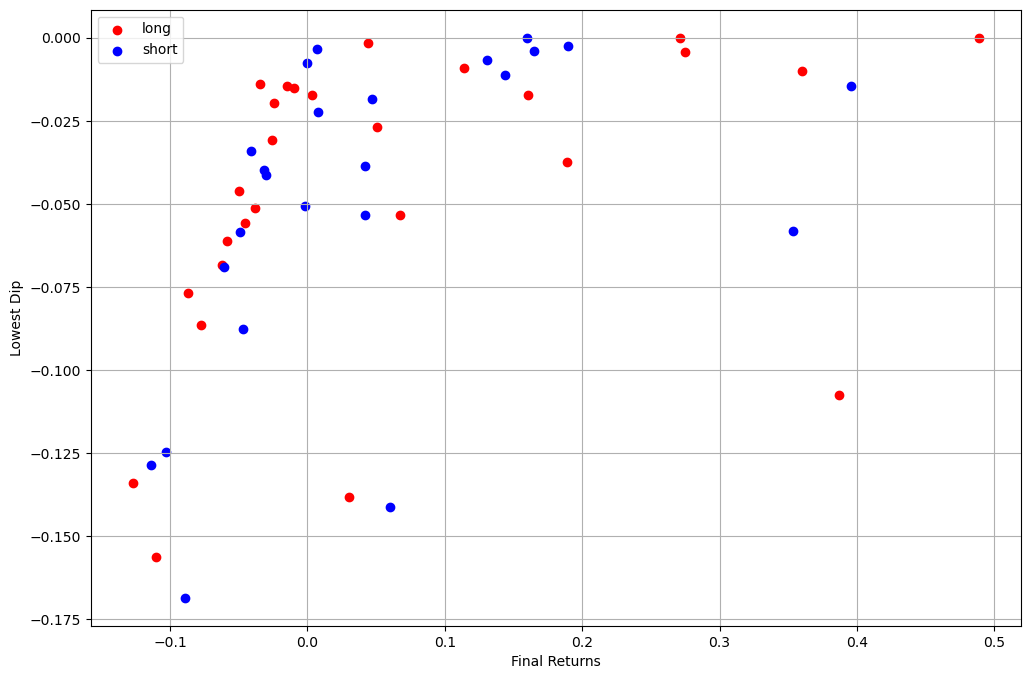

In [182]:
stoploss_plot(gen_logs(df_train, -0.25))

## Observations

In the above graph we can observe that lets say if we keep a 15% stop loss. Only the bottom 2 points will be affected. They will be capped to give a 15% loss, but without stoploss they only gave a 10% loss (approx). Hence it is not always necessary that a stoploss will indeed help our PNL, and the function above can easily help us to verify if having a stoploss would be helpful or not

## Dynamic Stoploss based on ATR

We will now try to improve our risk management system by incorporating a dynamic stoploss mechanism. The idea behind this is quite simple - to allow for a larger stoploss when the market is volatile, and a smaller stoploss when the market is not so volatile. We will use the ATR indicator to measure volatility, and tune the hyperparameters

We will update our generate logs function to incorporate this.

In [158]:
def gen_logs_v2(df):

    """
    Takes in input as dataframe (with the flag column),
    Output is a log file which contains +1 that indicates buy, -1 that indicates sell, and 0 to do nothing
    """
    
    #stoploss
    exit_loss = 0
    #disable trading to flag to be enabled, once we hit stoploss to stop trading
    disable_trading = 0
    compare = 0
     
    logs = []

    for i in range(len(df)):
        if df["flag"].iloc[i] == 1 and compare == 0:
            # No open trade, encouter buy singal
            exit_loss = 0
            buy_price = df["open"].iloc[i]
            ## Calculate the dynamic stoploss
            thresh = -df["sl_thresh"].iloc[i]
            
            compare = 1
            logs.append(1)

        #Once we open a trade, we have to check in df_fine whether to exit or not

        elif (df["flag"].iloc[i] != -1 and compare == 1):
            # Current buy trade, encounter buy signal or no signal - do nothing, update stop loss
            logs.append(0)

            #calculate pnl, if we exit now
            sell_price = df["open"].iloc[i]
            exit_loss = (sell_price - buy_price)/buy_price 
            

            #exit trade, if the loss is higher than stop loss
            if exit_loss < thresh and disable_trading == 0:
                logs[-1] = -1
                # print(f"disable_trading in buy trade - stop loss: {disable_trading}")
                disable_trading = 1


        elif df["flag"].iloc[i] == -1 and compare == 1:
            # Current buy trade, encounter sell signal

            #exit trade
            logs.append(-1)
            compare = 0
            exit_loss = 0

            #if trade was already exited before, check for disable trading flag here, do nothing here
            if disable_trading == 1:
                disable_trading = 0
   
                compare = -1 #the trade that we opened above is a sell trade


        #SHORT TRADES
        elif df["flag"].iloc[i] == -1 and compare == 0:
            # No open trade, enounter sell siganl 
            exit_loss = 0
            sell_price = df["open"].iloc[i]
            ## Calculate the dynamic stoploss
            thresh = -df["sl_thresh"].iloc[i]
            compare = -1
            logs.append(-1)


        elif (df["flag"].iloc[i] != 1 and compare == -1):
            # Current sell trade, encounter sell signal or no signal - do nothing, update stop loss
            logs.append(0)

            #calculate pnl, if we exit now
            buy_price = df["open"].iloc[i]
            exit_loss = (sell_price - buy_price)/sell_price 
        

            #exit trade, if the loss is higher than stop loss
            if exit_loss < thresh and disable_trading == 0:
                logs[-1] = 1
                # print(f"disable_trading in sell trade - stop loss: {disable_trading}")
                # print(i)
                disable_trading = 1

        elif df["flag"].iloc[i] == 1 and compare == -1:

            #exit trade
            logs.append(1)
            compare = 0
            exit_loss = 0

            #if trade was already exited before, check for disable trading flag here, do nothing here
            if disable_trading == 1:
                disable_trading = 0
                compare = 1

        elif df["flag"].iloc[i] == 0 and compare == 0:
            logs.append(0)

    #close out positions (if needed)
    
    logs = np.array(logs)

    if logs[-1] != 0 and np.sum(logs) != 0:
        logs[-1] = 0
    elif logs[-1] != 0 and np.sum(logs) == 0:
        pass
    else:
        logs[-1] = -np.sum(logs)

    df["logs"] = logs

    return df


In [159]:
## Hyperparameter Tuning

max_pnl = 0

train_test_split = 0.75

df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]


for period in [10 + 5*i for i in range(10)]:
    for multiplier in [5 + i for i in range(10)]:

        df["atr"] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=period).shift(1)
        df["sl_thresh"] = multiplier*df["atr"]/df["open"]
        df["sl_thresh"] = df["sl_thresh"].fillna(0)
        # print(min(df["sl_thresh"]), max(df["sl_thresh"]))


        train_test_split = 0.75

        df_train = df[0: int(train_test_split*len(df))]
        df_val = df[int(train_test_split*len(df)):]
        pnl_train = trade_analysis(gen_logs_v2(df_train))
        pnl_val = trade_analysis(gen_logs_v2(df_val))
      
        #Only improving on the train_pnl, printing the val_pnl to see if the model is not overfitting
        if pnl_train > max_pnl:
            print(f"PNL: {pnl_train.round(2)}, {pnl_val.round(2)}, params: {period, multiplier}")
        
            # Calculating the average stoploss when we enter the trades
            avg_sl = np.mean(df_train[df_train["logs"] != 0]["sl_thresh"])
            print(f"Average value of stoploss: {avg_sl}")
            max_pnl = pnl_train
        
    

PNL: 1.91, 0.6, params: (10, 5)
Average value of stoploss: 0.047105077924811035
PNL: 2.65, 0.98, params: (10, 6)
Average value of stoploss: 0.057091360682307093
PNL: 2.74, 0.92, params: (10, 7)
Average value of stoploss: 0.06742185896329418
PNL: 2.75, 1.49, params: (10, 9)
Average value of stoploss: 0.08535593456032131
PNL: 2.75, 1.52, params: (15, 9)
Average value of stoploss: 0.08349206215334698


## Observations

We see that we have been able to improve the train performace (2.75 over 2.6) without much loss on the validation dataset. Also note that, the average value of the stoploss is 8% which is lower than the optimal stoploss we had derived in the static case


## Improving upon Holding Time

Since we are atmost trading once every day, our holding time is going to be very high. The downside to this is that we have inherent long term exposure to the volatility of the cryptocurrency market. To overcome this, we wish to cap the maximum holding time to a certain threshold

We will first modify our trade_analysis function to calculate the holding time and calculate the maximum holding time and the current holding time of our current strategy

In [160]:
def trade_analysis_v2(df):

    df_trades= df[df["logs"] != 0].reset_index(drop = True)
 
    returns = []
    signals = []

    signs = []
    #array for hold_times
    hold_times = []

    for i in range(0, len(df_trades), 2):

        entry_price = df_trades["open"].iloc[i]
        exit_price = df_trades["open"].iloc[i+1]

        sign = df_trades["logs"].iloc[i]

        returns.append((exit_price-entry_price)/entry_price*sign)

        #append the hold times
        hold_times.append((df_trades["datetime"].iloc[i+1] - df_trades["datetime"].iloc[i]).days)


    return  len(returns), sum(returns) - 0.15/100*len(returns), hold_times

In [161]:
## Calculating the hold time of current strategy

#Use optimal values of ATR
period = 15
multiplier = 9
df["atr"] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=period).shift(1)
df["sl_thresh"] = multiplier*df["atr"]/df["open"]
df["sl_thresh"] = df["sl_thresh"].fillna(0)



train_test_split = 0.75

df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]
df_train = gen_logs_v2(df_train)
trades_train, pnl_train, hold_times = trade_analysis_v2(df_train)

print(f"Number of trades: {(trades_train)}")
print(f"Average hold time: {np.mean(hold_times)}, Maximum hold time: {max(hold_times)}")


Number of trades: 51
Average hold time: 15.333333333333334, Maximum hold time: 52


## Observations

We see that the maximum hold time is a whopping 52 days, with average holding time to be 15.33 days.



## Improvements 

We will now improve the holding time, by modifying our gen_logs function. We will now introduce a holding time cap on our trades (this in itself is a hyperparameter to tune), and observe whether we can improve holding time without sacrificing a lot of PNL

We will do this on the 1 hour dataset, since we will get a much better execution.

In [134]:
def gen_logs_v3(df, hold_time):

    #stoploss
    exit_loss = 0
    #disable trading to flag to be enabled, once we hit stoploss to stop trading
    disable_trading = 0
    compare = 0
     
    logs = []

    counter = 0
    i = 0

    while i < (len(df)):
        
        if df["flag"].iloc[i] == 1 and compare == 0:
            # No open trade, encouter buy singal
            exit_loss = 0
            buy_price = df["open"].iloc[i]
            thresh = -df["sl_thresh"].iloc[i]
            compare = 1
            logs.append(1)

        #Once we open a trade, we have to check in df_fine whether to exit or not

        elif (df["flag"].iloc[i] != -1 and compare == 1):
            # Current buy trade, encounter buy signal or no signal - do nothing, update stop loss
            logs.append(0)

            #calculate pnl, if we exit now
            sell_price = df["open"].iloc[i]
            exit_loss = (sell_price - buy_price)/buy_price 
            

            #exit trade, if the loss is higher than stop loss
            if exit_loss < thresh and disable_trading == 0:
                # print("Stop loss violated")
                # print(i)
                logs[-1] = -1
                # print(f"disable_trading in buy trade - stop loss: {disable_trading}")
                disable_trading = 1


        elif df["flag"].iloc[i] == -1 and compare == 1:
            # Current buy trade, encounter sell signal

            #exit trade
            logs.append(-1)
            compare = 0
            exit_loss = 0

            #if trade was already exited before, check for disable trading flag here, do nothing here
            if disable_trading == 1:
                disable_trading = 0
                # print(f"disable_trading in buy trade - while exiting: {disable_trading}")
                # logs[-1] = 0
                compare = -1


        #SHORT TRADES
        elif df["flag"].iloc[i] == -1 and compare == 0:
            # No open trade, enounter sell siganl 
            exit_loss = 0
            sell_price = df["open"].iloc[i]
            thresh = -df["sl_thresh"].iloc[i]
            compare = -1
            logs.append(-1)


        elif (df["flag"].iloc[i] != 1 and compare == -1):
            # Current sell trade, encounter sell signal or no signal - do nothing, update stop loss
            logs.append(0)

            #calculate pnl, if we exit now
            buy_price = df["open"].iloc[i]
            exit_loss = (sell_price - buy_price)/sell_price 
        

            #exit trade, if the loss is higher than stop loss
            if exit_loss < thresh and disable_trading == 0:
                logs[-1] = 1
                # print(f"disable_trading in sell trade - stop loss: {disable_trading}")
                # print(i)
                disable_trading = 1

        elif df["flag"].iloc[i] == 1 and compare == -1:
            # 
            # print("Current sell trade, encounter buy signal")
            # print(f"{disable_trading}")

            #exit trade
            logs.append(1)
            compare = 0
            exit_loss = 0

            #if trade was already exited before, check for disable trading flag here, do nothing here
            if disable_trading == 1:
                # print("Check")
                disable_trading = 0
                # logs[-1] = 0
                compare = 1

        elif df["flag"].iloc[i] == 0 and compare == 0:
            logs.append(0)

        ## If open trade, and we have not exceeded hold time, and then increment counter
        if compare != 0 and counter < hold_time and disable_trading == 0:
            counter += 1

        ## If open trade, and we have exceeded hold time, then exit trade, and open the next trade
        elif compare != 0 and counter >= hold_time and disable_trading == 0:
            logs[-1] = -compare

            if i + 1 >= len(df):
                pass
            else:
                i = i + 1
                logs.append(compare)
                counter = 1

        

        if compare == 0:
            # print("Check if loop needed")
            counter = 0

        i = i + 1
        
    #close out positions (if needed)
    
    logs = np.array(logs)

    if logs[-1] != 0 and np.sum(logs) != 0:
        logs[-1] = 0
    elif logs[-1] != 0 and np.sum(logs) == 0:
        pass
    else:
        logs[-1] = -np.sum(logs)

    df["logs"] = logs

    return df


In [136]:
max_pnl = 0

period = 15
multiplier = 9

df["atr"] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=period).shift(1)
df["sl_thresh"] = multiplier*df["atr"]/df["open"]
df["sl_thresh"] = df["sl_thresh"].fillna(0)


train_test_split = 0.75

df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]

## Multiply by 24 since we want to measure hold time in days, and our dataframe has 1 hour tick size
for ht in [2*24 + 24*i for i in range(20)]:
    trades_train, pnl_train, hold_times_train = trade_analysis_v2(gen_logs_v3(df_train, ht))
    trades_val, pnl_val, hold_time_val = trade_analysis_v2(gen_logs_v3(df_val, ht))
    if pnl_train > max_pnl:
        print(f"PNL: {pnl_train.round(2)}, {pnl_val.round(2)}, params: {ht}")
        print(f"Number of trades: {trades_train}")
        print(f"Maximum holding time: {max(hold_times_train)}, Average holding time: {np.mean(hold_times_train)}")

        print(np.mean(df_train[df_train["logs"] != 0]["sl_thresh"]))
        max_pnl = pnl_train

PNL: 2.36, 1.17, params: 48
Number of trades: 413
Maximum holding time: 2, Average holding time: 1.7893462469733656
0.0923225163408934
PNL: 2.5, 1.28, params: 96
Number of trades: 223
Maximum holding time: 4, Average holding time: 3.336322869955157
0.09300968241946574
PNL: 2.52, 1.31, params: 120
Number of trades: 183
Maximum holding time: 5, Average holding time: 4.076502732240437
0.09367134125564723
PNL: 2.58, 1.39, params: 216
Number of trades: 119
Maximum holding time: 9, Average holding time: 6.310924369747899
0.08691489776870204
PNL: 2.79, 1.37, params: 240
Number of trades: 112
Maximum holding time: 10, Average holding time: 6.714285714285714
0.09269601249396052
PNL: 2.79, 1.52, params: 456
Number of trades: 73
Maximum holding time: 19, Average holding time: 10.438356164383562
0.085506407254533


## Observations

We can see that if we have a maximum hold time of 19 days, our average holding time is 10 days (down from 15 days)
We can also reduce the maximum hold time to 9 days, and our aveage hold time becomes 6 days, but we have to lose around 40% returns over train + val. The loss comes mainly due to the transacrtion cost due to increased number of trades plus some inherent variance in multiple opening and closing trades

In [162]:
ht = 19*24

df_train = gen_logs_v3(df_train, ht)

df_val = gen_logs_v3(df_val, ht)
df = gen_logs_v3(df, ht)

df_filter = df_train[['datetime', 'open', 'high', 'low', 'close', 'volume', 'logs']]
df_filter.columns = ["datetime", 'open', 'high', 'low', 'close', 'volume', 'signal']
df_filter = df_filter.reset_index(drop=True)
df_filter
df_filter.to_csv(f'logs/macd_train.csv', index=False)

df_filter = df_val[['datetime', 'open', 'high', 'low', 'close', 'volume', 'logs']]
df_filter.columns = ["datetime", 'open', 'high', 'low', 'close', 'volume', 'signal']
df_filter = df_filter.reset_index(drop=True)
df_filter
df_filter.to_csv(f'logs/macd_val.csv', index=False)

df_filter = df[['datetime', 'open', 'high', 'low', 'close', 'volume', 'logs']]
df_filter.columns = ["datetime", 'open', 'high', 'low', 'close', 'volume', 'signal']
df_filter = df_filter.reset_index(drop=True)
df_filter
df_filter.to_csv(f'logs/macd_comb.csv', index=False)

## Generting the logs on the train + validation dataset (complete logs)

Run this cell to run the complete strat, and generate the logs on the train dataset

In [ ]:
df_fine = pd.read_csv("data/btcusdt_1h_train.csv")
df_fine["datetime"] = pd.to_datetime(df_fine["datetime"])
df_fine = df_fine.drop(columns = ["Unnamed: 0"])


#Select a particular timestamp, and filter the original dataframe to obtain daily data
time_stamp = "21:30:00"
df = df_fine[df_fine['datetime'].dt.time == pd.to_datetime(time_stamp).time()]



fast = 14
slow = 20
signal = 14
macd, signal, _ = talib.MACD(df["open"], fastperiod=fast, slowperiod=slow, signalperiod=signal)
df['macd'] = macd
df['signal'] = signal

display(df)

signal_thresh = 500
shifted_signal = df['signal'].shift(1)
df['flag'] = np.where(np.logical_and(df['signal'] > shifted_signal, abs(df["signal"]) < signal_thresh), 1, 0)
df['flag'] = np.where(np.logical_and(df['signal'] < shifted_signal, abs(df["signal"]) < signal_thresh), -1, df['flag'])


period = 15
multiplier = 9

df["atr"] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=period).shift(1)
df["sl_thresh"] = multiplier*df["atr"]/df["open"]
df["sl_thresh"] = df["sl_thresh"].fillna(0)


df = df.drop(columns= ["open", "high", "low", "close", "volume"])
df = df_fine.merge(df, on='datetime', how='left')
df = df.fillna(0)

train_test_split = 0.75

df_train = df[0: int(train_test_split*len(df))]
df_val = df[int(train_test_split*len(df)):]

df_train = gen_logs_v3(df_train, ht)

df_val = gen_logs_v3(df_val, ht)
df = gen_logs_v3(df, ht)

df_filter = df_train[['datetime', 'open', 'high', 'low', 'close', 'volume', 'logs']]
df_filter.columns = ["datetime", 'open', 'high', 'low', 'close', 'volume', 'signal']
df_filter = df_filter.reset_index(drop=True)
df_filter
df_filter.to_csv(f'logs/macd_train.csv', index=False)

df_filter = df_val[['datetime', 'open', 'high', 'low', 'close', 'volume', 'logs']]
df_filter.columns = ["datetime", 'open', 'high', 'low', 'close', 'volume', 'signal']
df_filter = df_filter.reset_index(drop=True)
df_filter
df_filter.to_csv(f'logs/macd_val.csv', index=False)

df_filter = df[['datetime', 'open', 'high', 'low', 'close', 'volume', 'logs']]
df_filter.columns = ["datetime", 'open', 'high', 'low', 'close', 'volume', 'signal']
df_filter = df_filter.reset_index(drop=True)
df_filter
df_filter.to_csv(f'logs/macd_comb.csv', index=False)


## Generating the Logs on the test dataset

Run this cell to generate logs on the test dataset (this also includes train + val)

In [163]:
#test dataset
df_fine = pd.read_csv("data/btcusdt_1h.csv")
df_fine["datetime"] = pd.to_datetime(df_fine["datetime"])
# df_fine = df_fine.drop(columns = ["Unnamed: 0"])


#Select a particular timestamp, and filter the original dataframe to obtain daily data
time_stamp = "21:30:00"
df = df_fine[df_fine['datetime'].dt.time == pd.to_datetime(time_stamp).time()]



fast = 14
slow = 20
signal = 14
macd, signal, _ = talib.MACD(df["open"], fastperiod=fast, slowperiod=slow, signalperiod=signal)
df['macd'] = macd
df['signal'] = signal

display(df)

signal_thresh = 500
shifted_signal = df['signal'].shift(1)
df['flag'] = np.where(np.logical_and(df['signal'] > shifted_signal, abs(df["signal"]) < signal_thresh), 1, 0)
df['flag'] = np.where(np.logical_and(df['signal'] < shifted_signal, abs(df["signal"]) < signal_thresh), -1, df['flag'])


period = 15
multiplier = 9

df["atr"] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=period).shift(1)
df["sl_thresh"] = multiplier*df["atr"]/df["open"]
df["sl_thresh"] = df["sl_thresh"].fillna(0)


df = df.drop(columns= ["open", "high", "low", "close", "volume"])
df = df_fine.merge(df, on='datetime', how='left')
df = df.fillna(0)

ht = 19*24

df = gen_logs_v3(df, ht)

df_filter = df[['datetime', 'open', 'high', 'low', 'close', 'volume', 'logs']]
df_filter.columns = ["datetime", 'open', 'high', 'low', 'close', 'volume', 'signal']
df_filter = df_filter.reset_index(drop=True)
df_filter
df_filter.to_csv(f'logs/macd_comb_final.csv', index=False)



,datetime,open,high,low,close,volume,macd,signal
16,2018-01-01 21:30:00,13247.00,13247.08,12966.42,13018.00,367.393566,NaN,NaN
40,2018-01-02 21:30:00,13690.02,13842.88,13584.99,13590.02,1020.856756,NaN,NaN
64,2018-01-03 21:30:00,15045.00,15130.00,14901.93,15010.06,477.866959,NaN,NaN
87,2018-01-04 21:30:00,14367.99,14494.99,14238.01,14469.97,1129.730622,NaN,NaN
111,2018-01-05 21:30:00,16094.99,16500.00,16087.73,16449.00,1007.615517,NaN,NaN
...,...,...,...,...,...,...,...,...
35103,2022-01-07 21:30:00,41310.85,42315.85,40917.66,42135.26,4909.626750,-770.720873,-572.483488
35127,2022-01-08 21:30:00,41609.60,41740.53,41238.08,41346.01,1715.070630,-880.167934,-613.508081
35151,2022-01-09 21:30:00,41621.11,42146.25,41556.49,42143.04,1325.347680,-954.373116,-658.956752
35175,2022-01-10 21:30:00,40984.34,41985.99,40850.03,41904.40,4663.471580,-1024.698282,-707.722289
